### Aleksandr Belov

## Attention !!!
- If you want to retrain the stacking in task 3, use `IS_FITTING = True`;
- If you want to load the pickle model use `IS_FITTING = False`.

In [0]:
IS_FITTING = True

# Home Assignment No. 2: Part 1 (Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

## Task 1.1. Boosting, part 1. (2 points)


> Boosting Machines (BM) are a family of widely popular and effective methods for classification and regression tasks. The main idea behind BMs is that **combining weak learners**, that perform slightly better than random, can result in **strong learning models**.

> AdaBoost utilizes the greedy training approach: firstly we train the weak learners (they are later called `base_classifiers`) on the whole dataset and in the next iterations we train the model on the samples, on the which the previous models have performed poorly. This behavior is acheived by reweighting the training samples during each algorithm's step. 

#### The task:

In this exercise you will be asked to implement one of the earlier variants of BMs - **AdaBoost** and compare it to the already existing `sklearn` implementation. The key steps are:

* Complete the `ada_boost_alpha` and `ada_boost_distribution` functions

* Complete the `.fit` method of `Boosting` class

* Complete the `.predict` method of `Boosting` class

The pseudocode for AdaBoost can be found in [Lecture 7](https://github.com/adasegroup/ML2020_lectures).

##### criteria

the decision boundary of the final implementation should look reasonably identical to the model from `sklearn`, and should achieve accuracy close to `scikit` :

$$
    |\text{your_accuracy} - \text{sklearn_accuracy}| \leq 0.005
\,. $$

#### Place for ypur solution

In [0]:
%matplotlib inline

#My imports
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [0]:
RANDOM_STATE = 1

In [0]:
### Plot the dataset

X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)

# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

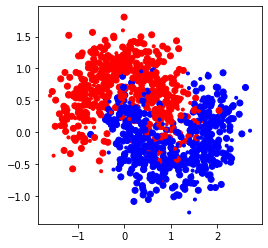

In [6]:
# Plot the training points
plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright)

base classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier

* `ada_boost_alpha` - function, which calculates the weights of the linear combination of the classifiers
* `ada_boost_distribution` - function, which calculates sample weights

Implement htese procedures

In [0]:
### Now let us define functions to calculate alphas and distributions for AdaBosot algorithm

def ada_boost_alpha(y, y_pred_t, distribution):
    """
    y_pred_t is a prediction of the t-th base classifier
    """

    is_correct = (y != y_pred_t).astype(np.uint8)
    N_t = np.dot(distribution, is_correct)

    alpha = 0.5 * np.log((1-N_t)/(N_t + 1e-9) + 1e-9) 

    return alpha

In [0]:
def ada_boost_distribution(y, y_pred_t, distribution, alpha_t):
    """
    y_pred_t is a prediction of the t-th base classifier
    """

    distribution = distribution * np.exp(-y*y_pred_t*alpha_t)
    distribution /= distribution.sum()

    return distribution

Our custom boosting class

In [0]:
class Boosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. 
                            Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, 
                      prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, 
                             prediction, alphas and actual labels
    """

    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=ada_boost_alpha, update_distribution=ada_boost_distribution):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution

    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        self.alphas = np.zeros(self.n_estimators)
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())     
            self.classifiers[-1].fit(X, y, sample_weight=distribution)

            # ======= Your code here ======

            # make a prediction
            y_pred_t = self.classifiers[-1].predict(X)

            #update alphas, append new alpha to self.alphas
            self.alphas[i] = self.get_alpha(y, y_pred_t, distribution)

            # update distribution and normalize
            distribution = self.update_distribution(y, y_pred_t, distribution, self.alphas[i])

    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])

        # ====== Your code here ======
        #get the weighted votes of the classifiers
        preds = np.asarray([clf.predict(X) for clf in self.classifiers])
        out = np.dot(self.alphas, preds)
        out = np.sign(out)

        return out

In [11]:
from sklearn.ensemble import AdaBoostClassifier

max_depth = 5
n_estimators = 100

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth, random_state=RANDOM_STATE)
ada_boost1 = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf)
t_ada = time()
ada_boost1.fit(X_train, y_train)
t_ada = time() - t_ada

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [0]:
classifiers = [ada_boost1, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.875
accuracy ada_boost_sklearn: 0.875


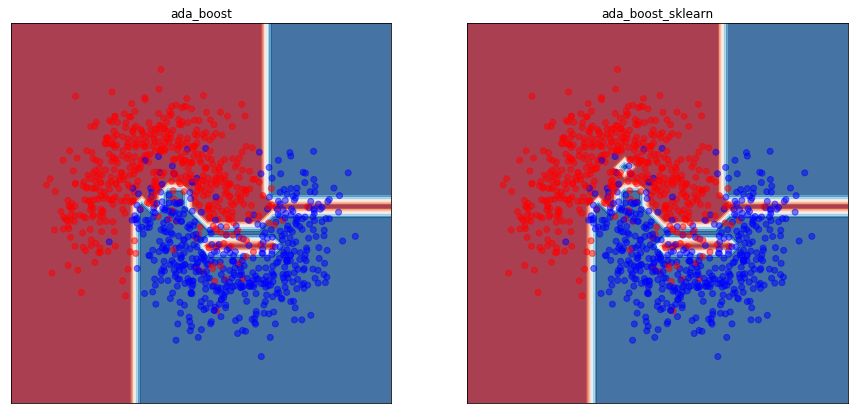

In [13]:
# # test ensemble classifier
def plot_decision_space(classifiers, names, X_test, y_test):
    plt.figure(figsize=(15, 7))
    for i, clf in enumerate(classifiers):
        prediction = clf.predict(X_test)

        # Put the result into a color plot
        ax = plt.subplot(1, len(classifiers), i + 1)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(names[i])

        print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

plot_decision_space(classifiers, names, X_test, y_test)

## Task 1.2. Boosting, part 2. (2 points)

For adaboost we have computed each alpha according to the formula:

$$\alpha_t = \frac{1}{2}\log{\frac{1-N_T(h_T, w_T )}{N_T(h_T,w_t)}}$$

In the next task you will be asked to instead recompute all of the alphas after adding another estimator to the composition of models, i.e. when the new classifier is fitted to the weighted data samples, the new alphas should be recomputed by directly minimizing the exponential loss, for all the avaliable estimators. Take into account, that at each step of the boosting algorithm **all** alphas and, consequntly, **all** sample weights should be recomputed from scratch. 

**The task**:
* Complete the `recompute_alpha` and `recompute_distribution` functions
* Complete the `.fit` method of `RecomputeBoosting` class
* Complete the `.predict` method of `RecomputeBoosting` class
* Plot the final alphas (last calculated in case of recomputed alphas)
* plot the history scores of the resulting model at each iteration (use ```predict```, ```score``` and ```construct_alpha_history``` functions defined below) for both RecomputedBoosting and AdaBoost (it can be either your own implementation from Exercise 1.1 or the one from sklearn - in this case use ```.estimator_weights_```, ```.estimators_```)
* Make a conclusion about which method is better and in which case - in order to do that you can additionally vary the parameters of training: number and depth of the estimators, noise of the data (moons)

**HINTS:**

In order to minimize the exponential loss with respect to alpha, use the [```scipy.optimize.minimize```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.

When defining the function to minimize (in case of AdaBoost it should be the exponential loss), have a look at the optimization problem formulation of Ridge Regression and at the reguralization parameter([Lecture 2, slide 14](https://github.com/adasegroup/ML2020_lectures/blob/master/lecture2/Lecture_2_Regression.pdf)). Add it in order to guarantee the existence of the solution.

In [0]:
from scipy.optimize import minimize

In [0]:
def recompute_alpha(y, y_pred, C):
    """
    y_pred - is a list of predictions of the existing estimators
    C - is a reguralization term    
    """
    # ====== Your code here =====
    m = len(y)
    T = len(y_pred)
    alphas = np.zeros(T)

    exp_loss = lambda alphas: np.exp(-y*np.dot(y_pred.T, alphas))
    loss = lambda alphas: np.sum(exp_loss(alphas)) / m + np.linalg.norm(alphas)**2 / C
    loss_grad = lambda alphas: -np.dot(y_pred, y*exp_loss(alphas)) / m + 2/C * alphas

    res = minimize(loss, alphas, method='BFGS', jac=loss_grad)
    alphas = res.x

    return alphas


def recompute_distribution(y, y_pred, alphas):
    """
    y_pred - is a list of predictions of the existing estimators
    alphas - are the last recomputed alphas
    """

    # ====== Your code here =====
    distribution = np.exp(-y*np.dot(y_pred.T, alphas))
    distribution /= distribution.sum()

    return distribution

In [0]:
class RecomputedBoosting():
    """
    Generic class for construction of boosting models

    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. 
                            Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, 
                      prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution,
                             prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=recompute_alpha, update_distribution=recompute_distribution, C=1.0):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        self.C = C

    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []

        #notice how alpha is a matrix - we will store the history of the updates here
        self.alphas = np.zeros((self.n_estimators, self.n_estimators))
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())        
            self.classifiers[-1].fit(X, y, sample_weight=distribution)

            # ======= Your code here ======
            # create a list of predictions across all classifiers
            y_pred = np.asarray([clf.predict(X) for clf in self.classifiers])

            # recalculate alphas, add them to the matrix of self.alphas
            self.alphas[i, :i+1] = self.get_alpha(y, y_pred, self.C)

            # NOTE: here, self.alphas is a history of computed alphas at each step i
            # update distribution and normalize
            distribution = self.update_distribution(y, y_pred, self.alphas[i, :i+1])
          
        return self

    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])

        # ====== Your code here ======
        #get the weighted votes of the classifiers
        #do not forget that self.alphas is the whole history of recalculated alphas!
        preds = np.asarray([clf.predict(X) for clf in self.classifiers])
        out = np.dot(self.alphas[-1], preds)
        out = np.sign(out)

        return out

In [17]:
from sklearn.ensemble import AdaBoostClassifier

recomputed_ada_boost = RecomputedBoosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf, get_alpha=recompute_alpha, 
                     update_distribution=recompute_distribution, C=1.0)

t_recomputed = time()
recomputed_ada_boost.fit(X_train, y_train)
t_recomputed = time() - t_recomputed

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [0]:
classifiers = [recomputed_ada_boost, ada_boost_sklearn]
names = ['recomputed_ada_boost', 'ada_boost_sklearn']

accuracy recomputed_ada_boost: 0.92
accuracy ada_boost_sklearn: 0.875


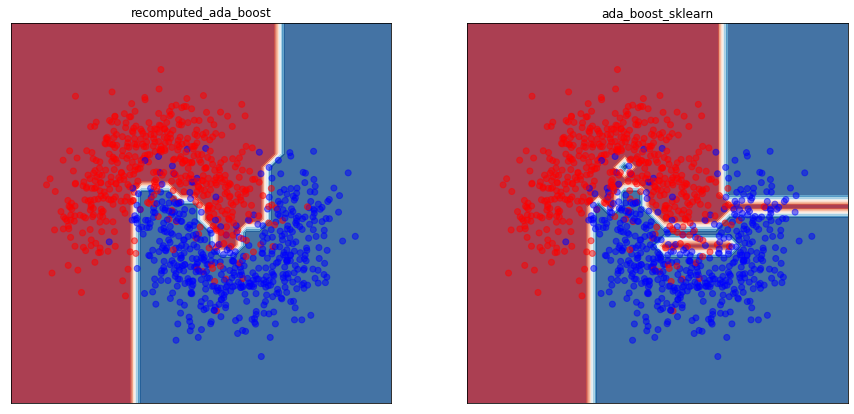

In [19]:
plot_decision_space(classifiers, names, X_test, y_test)

accuracy recomputed_ada_boost (max_depths=3, n_est=100): 0.9
accuracy ada_boost_sklearn (max_depths=3, n_est=100): 0.875
|-----------------|

accuracy recomputed_ada_boost (max_depths=5, n_est=100): 0.92
accuracy ada_boost_sklearn (max_depths=5, n_est=100): 0.875
|-----------------|

accuracy recomputed_ada_boost (max_depths=7, n_est=100): 0.88
accuracy ada_boost_sklearn (max_depths=7, n_est=100): 0.875
|-----------------|

accuracy recomputed_ada_boost (max_depths=3, n_est=300): 0.905
accuracy ada_boost_sklearn (max_depths=3, n_est=300): 0.9
|-----------------|

accuracy recomputed_ada_boost (max_depths=5, n_est=300): 0.915
accuracy ada_boost_sklearn (max_depths=5, n_est=300): 0.9
|-----------------|

accuracy recomputed_ada_boost (max_depths=7, n_est=300): 0.875
accuracy ada_boost_sklearn (max_depths=7, n_est=300): 0.9
|-----------------|



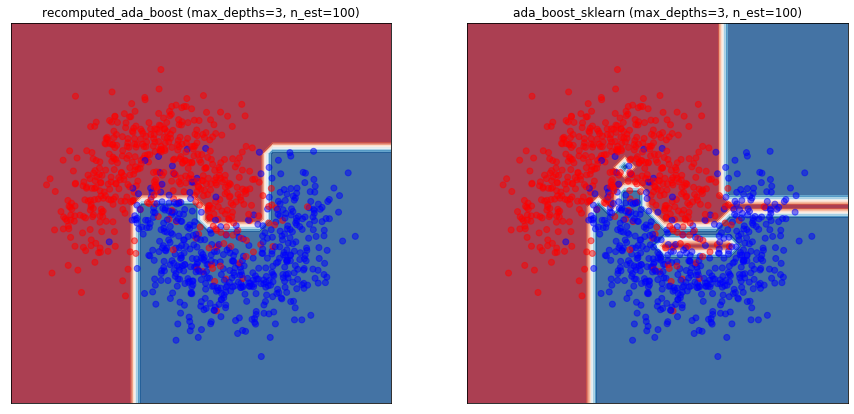

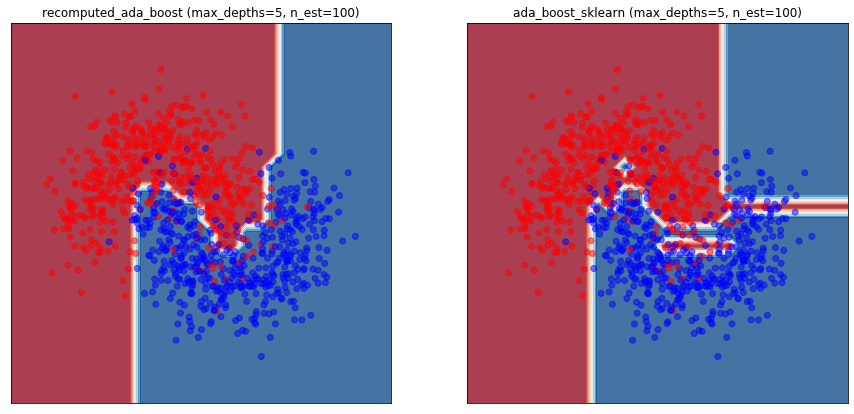

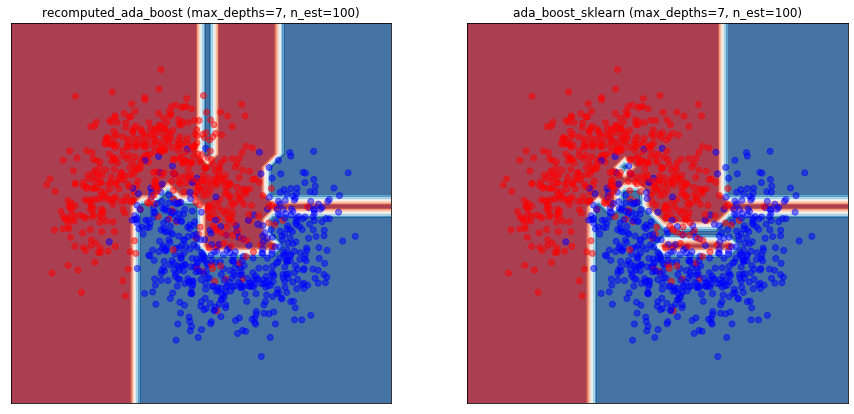

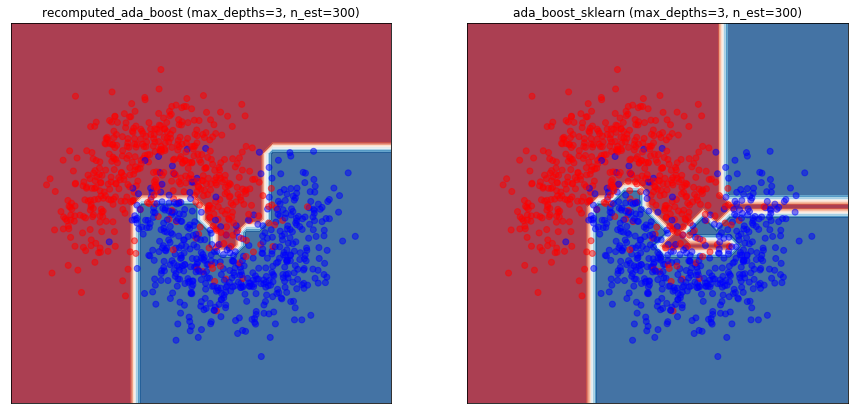

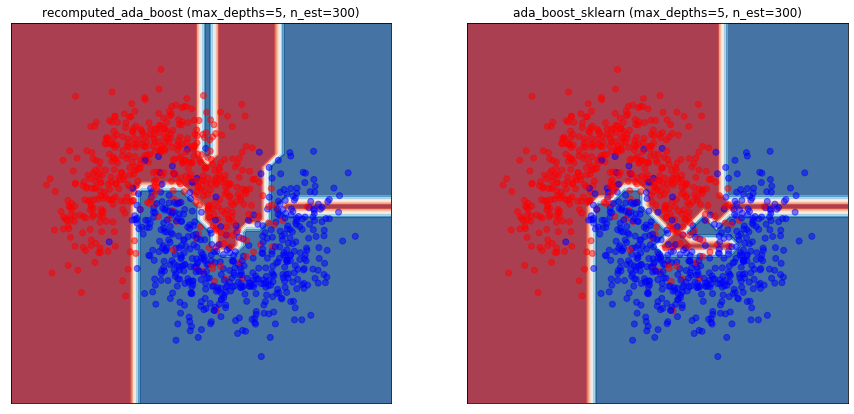

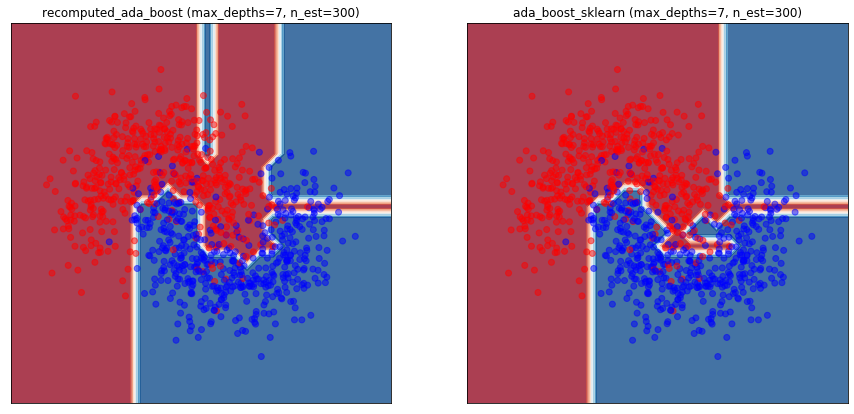

In [20]:
depths = [3, 5, 7, 3, 5, 7]
n_ests = [100, 100, 100, 300, 300, 300]

for d, n in zip(depths, n_ests):
    get_base_clf = lambda: DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)

    rb = RecomputedBoosting(n_estimators=n,
                        base_classifier=get_base_clf, get_alpha=recompute_alpha, 
                        update_distribution=recompute_distribution, C=1.0).fit(X_train, y_train)

    ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth), 
                                          algorithm="SAMME",
                                          n_estimators=n).fit(X_train, y_train)

    clfs = [rb, ab]
    plot_decision_space(clfs, [f'{name} (max_depths={d}, n_est={n})' for name in names], X_test, y_test)
    print('|-----------------|\n')

In [0]:
from sklearn.metrics import accuracy_score


def score(alphas, estimators, X, y):
    return accuracy_score(y, predict(alphas, estimators, X))


def predict(alphas, estimators, X, y=None):
    return np.sign(sum(
        b * e.predict(X) for b, e in zip(alphas, estimators)
    ))


def construct_alpha_history(init_alphas):
    """
    construct alpha history, alike recomputed alpha history, for AdaBoost algorithm
    """
    alphas = np.zeros((len(init_alphas), len(init_alphas)))
    for t, alpha in enumerate(init_alphas):
        alphas[t:, t] = alpha
    return alphas

In [0]:
ada_boost_alpha_history = construct_alpha_history(ada_boost1.alphas)
recomputed_ada_boost_alpha_history = recomputed_ada_boost.alphas

alpha_histories = [ada_boost_alpha_history, recomputed_ada_boost_alpha_history]
classifiers = [ada_boost1.classifiers, recomputed_ada_boost.classifiers]
names = ['ada_boost', 'recomputed_ada_boost']

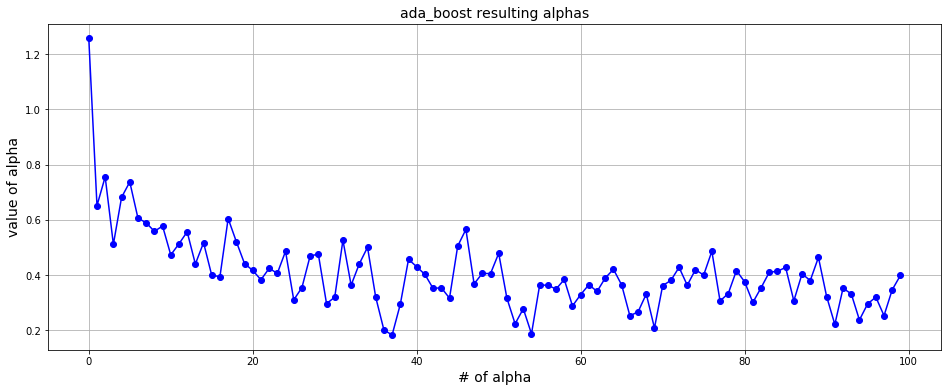

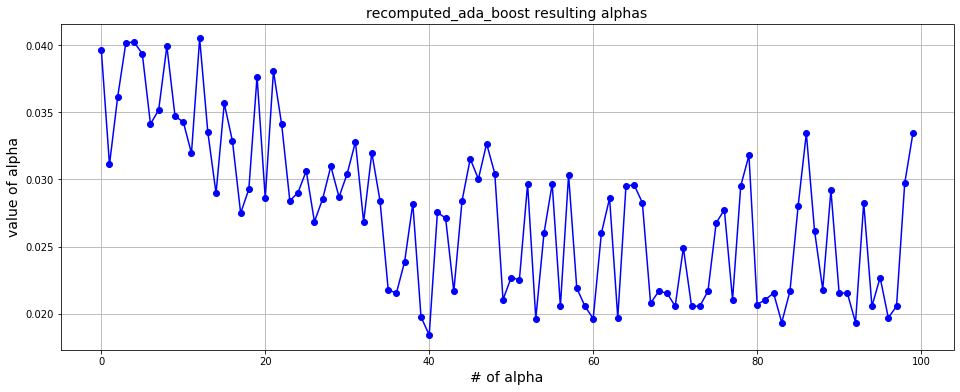

In [24]:
## Plot the resulting alphas (last calculated in case of recomputed alphas)

for i, alphas in enumerate(alpha_histories):

    plt.figure(figsize=(16, 6))
    plt.plot(alphas[-1], 'b-o')
    plt.title(f'{names[i]} resulting alphas', fontsize=14)
    plt.xlabel('# of alpha', fontsize=14)
    plt.ylabel('value of alpha', fontsize=14)
    plt.grid()
    plt.show()

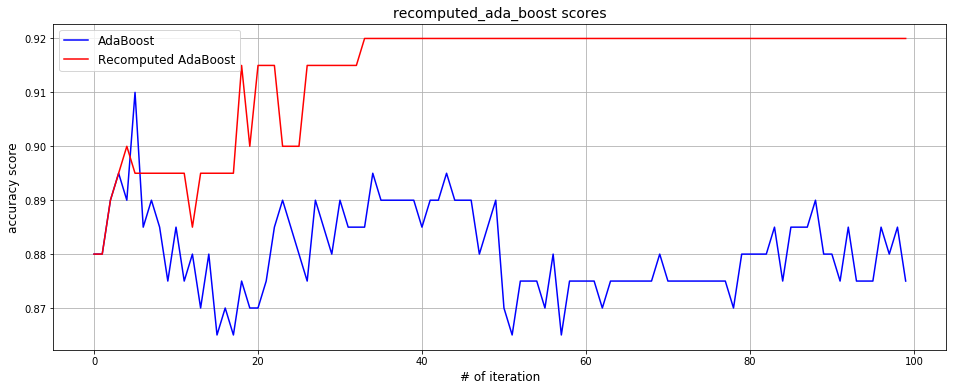

In [25]:
## Plot the scores of the models at each iteration (each iteration - each estimator added to the ensemble) 
## for AdaBoost and RecomputedAdaBoost

scores_ada_boost = [score(ada_boost_alpha_history[t][:t+1], 
                          classifiers[0][:t+1], X_test, y_test) 
                    for t in range(n_estimators)]
scores_ada_boost_recomputed = [score(recomputed_ada_boost_alpha_history[t][:t+1], 
                                     classifiers[1][:t+1], X_test, y_test) 
                    for t in range(n_estimators)]

plt.figure(figsize=(16, 6))
plt.plot(scores_ada_boost, 'b', label='AdaBoost')
plt.plot(scores_ada_boost_recomputed, 'r', label='Recomputed AdaBoost')
plt.title(f'{names[i]} scores', fontsize=14)
plt.xlabel('# of iteration', fontsize=12)
plt.ylabel('accuracy score', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()      

Make a conclusion about which method is better and in which case. 

Your answer

In [26]:
print(f'AdaBoost training time: {t_ada:.3f} sec')
print(f'Recomputed AdaBoost training time: {t_recomputed:.3f} sec')
print(f'Ratio: {t_recomputed/t_ada:.2f}')

AdaBoost training time: 0.188 sec
Recomputed AdaBoost training time: 2.633 sec
Ratio: 13.98


`Recomputed AdaBoost` has better quality then general `AdaBoost` in almost all cases. Also `Recomputed AdaBoost` is  more robust for outliers for some parameters. But its training time is more than 10 times longer.


 - `Recomputed AdaBoost` is good for the classification problems. But you should have enough time or computational resources for training on a big dataset. But it has the overfitting problem too.
 - General `AdaBoost` gives greater weight to outliers and can be used for Anomaly Detection problem.

## Task 2. Gradient Boosting and Feature Selection (1 point)

Gradient Boosting Machines (GBM) are a historical and logical continuation of the first boosting algorithms. In a way, one can consider AdaBoost as another variant of GBMs. These methods are the extremely powerful tools, widely used in industry, research and various machine learning competitions. 

In this task we offer to focus on one varinat of GBM called [XGBoost](https://github.com/dmlc/xgboost/tree/master/python-package). The dataset that is going to be used is  [Telecom Churn Dataset] (https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). You will need to construct an XGBoost classification model, train it, plot the ROC curve, measure the training time and compare it to Random Forest. Afterwards, compare the models' feature importances. 

**The task**
* train the XGBoost classifier on the provided dataset
  * measure the training time
  * measure the precision/recall on the test set
  * plot ROC-curve

* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

* compare the feature importances of the trained XGBoost and Random Forest Classifiers. Why do you think they are different? Explain.

* for each model, sort the features by their importance, and plot the dependence of the test score on the number of features selected by best importance

*Fit the models to the iteratively reduced subset of features -in order to do that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall.

**HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

Make sure that you have installed the XGBoost package before starting the task. 

**HINT**: in order to measure the training time you can use [**timeit** cell magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit). 

In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# My imports
import seaborn as sns
from sklearn.metrics import (classification_report, roc_curve, roc_auc_score, 
                             precision_recall_curve, average_precision_score
                            )
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel

data = pd.read_csv('data/telecom_churn.csv')
cols = ['account length','number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn']

data = data[cols]
data.iloc[:,-1] = pd.Categorical(data.iloc[:,-1])
data.iloc[:,-1] = data.iloc[:,-1].cat.codes
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=RANDOM_STATE)

* train the XGBoost classifier on the provided dataset
* measure the training time
* measure the precision/recall on the test set
* plot ROC-curve
* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

In [0]:
###YOUR CODE###
tree_based_params = {'n_estimators': 300, 'max_depth': 3, 
                     'n_jobs': -1, 'random_state': RANDOM_STATE
                    }

xgb = XGBClassifier(**tree_based_params)
rf = RandomForestClassifier(**tree_based_params)

clfs = [xgb, rf]
clf_names = ['XGBoost', 'RF']

In [32]:
%%timeit
xgb.fit(X_train, y_train)

1 loop, best of 3: 444 ms per loop


In [33]:
%%timeit
rf.fit(X_train, y_train)

1 loop, best of 3: 720 ms per loop


In [34]:
for name, clf in zip(clf_names, clfs):
    y_pred = clf.predict(X_test)
    print(f'{name} classification report\n')
    print(classification_report(y_test, y_pred))

XGBoost classification report

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1136
           1       0.84      0.49      0.62       198

    accuracy                           0.91      1334
   macro avg       0.88      0.74      0.78      1334
weighted avg       0.91      0.91      0.90      1334

RF classification report

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1136
           1       1.00      0.14      0.25       198

    accuracy                           0.87      1334
   macro avg       0.93      0.57      0.59      1334
weighted avg       0.89      0.87      0.83      1334



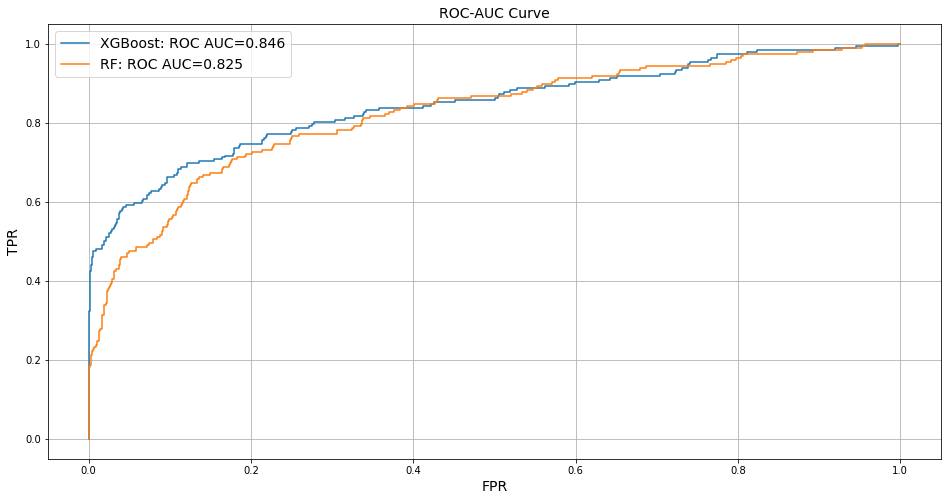

In [35]:
plt.figure(figsize=(16, 8))

for name, clf in zip(clf_names, clfs):
    probs = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)

    plt.plot(fpr, tpr, label=f'{name}: ROC AUC={auc:.3f}')

plt.grid()
plt.legend(loc='best', fontsize=14)
plt.title('ROC-AUC Curve', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.show()

* extract and compare the feature importances calculated by the previously trained XGBoost and Random Forest Classifiers. Are they different or the same, why?

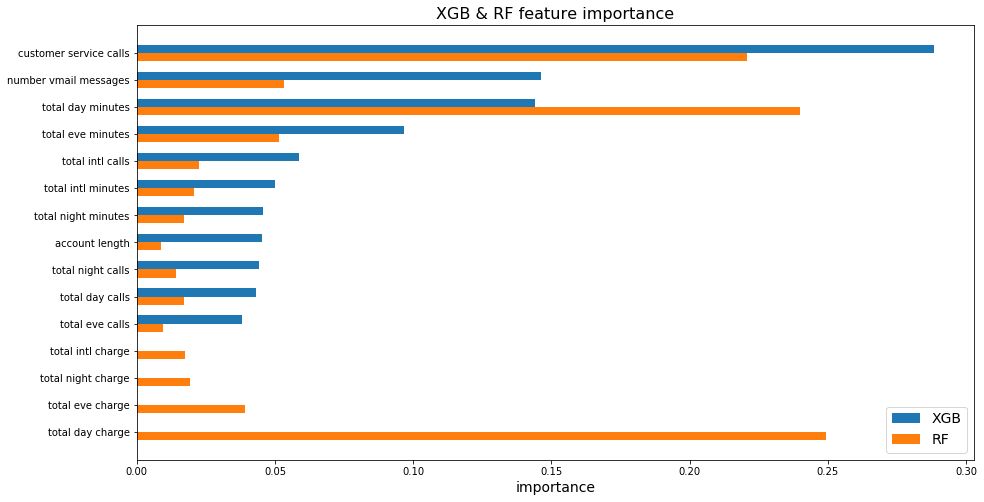

In [36]:
feature_names = np.asarray(cols[:-1])

fi_xgb = xgb.feature_importances_
fi_rf = rf.feature_importances_

sorted_idx = np.argsort(fi_xgb)

plt.figure(figsize=(15, 8))

x = np.arange(len(feature_names))

plt.barh(x+0.15, fi_xgb[sorted_idx], 0.3, label='XGB')
plt.barh(x-0.15, fi_rf[sorted_idx], 0.3, label='RF')
plt.yticks(x, feature_names[sorted_idx])

plt.title('XGB & RF feature importance', fontsize=16)
plt.xlabel('importance', fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

Feature importances are different.

- `XGBoost` has regularization and it helps for the feature selections: *some features have zero-importance*. 

* Fit the models to the iteratively reduced subset of features -in order to fo that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall. **HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

In [0]:
max_fi = min(xgb.feature_importances_.max(), rf.feature_importances_.max()) - 0.01
thresholds = np.linspace(0, max_fi, 100)

In [0]:
###YOUR CODE###
clfs_reduced = [lambda: XGBClassifier(**tree_based_params),
                lambda: RandomForestClassifier(**tree_based_params)
               ]

pr_scores = np.zeros((2, len(thresholds)))

for i, prefited_clf in enumerate(clfs):
    for j, th in enumerate(thresholds):
        selectfrommodel = SelectFromModel(prefited_clf, th, prefit=True)
        X_reduced_train = selectfrommodel.transform(X_train)
        X_reduced_test = selectfrommodel.transform(X_test)

        clf = clone(prefited_clf).fit(X_reduced_train, y_train)
        probs = clf.predict_proba(X_reduced_test)[:, 1]

        pr_scores[i, j] = average_precision_score(y_test, probs)

XGB opt th: 0.043, score: 0.707
RF opt th: 0.022, score: 0.631


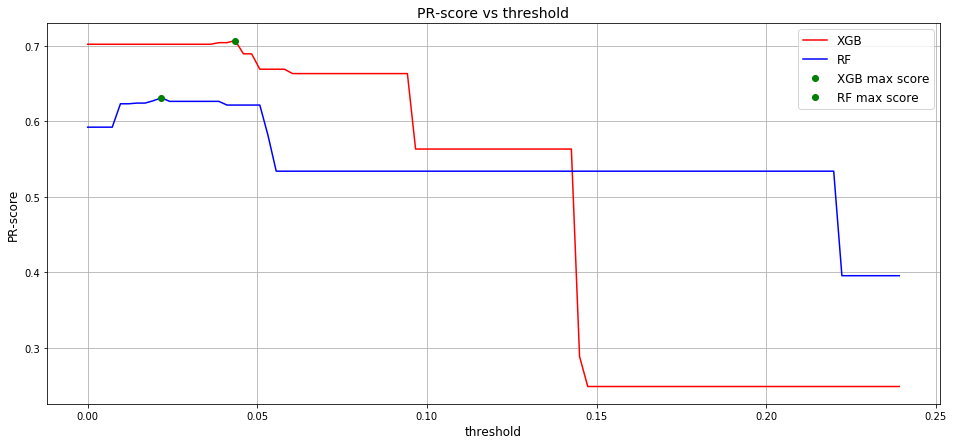

In [39]:
th_max_xgb = np.argmax(pr_scores[0])
th_max_rf = np.argmax(pr_scores[1])

print(f'XGB opt th: {thresholds[th_max_xgb]:.3f}, score: {pr_scores[0][th_max_xgb]:.3f}')
print(f'RF opt th: {thresholds[th_max_rf]:.3f}, score: {pr_scores[1][th_max_rf]:.3f}')

plt.figure(figsize=(16, 7))

plt.plot(thresholds, pr_scores[0], 'r', label='XGB')
plt.plot(thresholds, pr_scores[1], 'b', label='RF')
plt.plot(thresholds[th_max_xgb], pr_scores[0][th_max_xgb], 'go', label='XGB max score')
plt.plot(thresholds[th_max_rf], pr_scores[1][th_max_rf], 'go', label='RF max score')

plt.ylabel('PR-score', fontsize=12)
plt.xlabel('threshold', fontsize=12)
plt.title(f'PR-score vs threshold', fontsize=14)
plt.legend(loc='best', fontsize=12)

plt.grid()
plt.show()

We saw that:
- with `th ~= 0.0043` we got the biggest `PR-score = 0.707` for `XGBoost` 
- with `th ~= 0.0022` we got the biggest `PR-score = 0.631` for `RF`.

# Task 3. Bayesian methods (1 point)

In this task you are asked to compare the performance of the common Ridge Regression with its the parameters chosen using cross-validation technique and Bayesian Ridge Regression. 

In particular, using [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html), find the optimal value for the reguralization coefficient in the ridge regression optimization problem formulation. Then train [Bayesian Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) and compare the absolute error and learnt coefficients distribution for both variants and make some conclusions on both methods.

**The task:** 
* Use crossvalidation technique to choose the optimal value of reguralization coefficent for Ridge Regression model. (**Note:** "optimal" value here, means the one that lets the model with this particular parameter value achieve better performance compared to the other variants). 
* Fit Bayesian Ridge Regression model 
* Plot the absolute error historgramms for both models using [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html).
* Plot historgrams of coefficients of regression derived from both models (in cross-validation case the coefficients of the best model)
* Compare the two pairs of histrograms. Are they the same or different? Why? What are the prons and cons of both methods?

In [0]:
import sklearn.datasets as dt
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, BayesianRidge
import seaborn as sns

# My imports
from sklearn.metrics import mean_squared_error

In [41]:
X, y = dt.load_boston(return_X_y=True)
X_train = X[:400]
y_train = y[:400]
X_test = X[400:]
y_test = y[400:]

X.shape

(506, 13)

### GridSearchCV

In [42]:
%%time
###YOUR CODE###

alphas = sorted(np.random.uniform(0.00001, 10, 1000))

params = {'alpha' : alphas}
ridge = Ridge(random_state=RANDOM_STATE, normalize=True)

gs_ridge = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', 
                                       cv=4, n_jobs=-1)
gs_ridge.fit(X_train, y_train)
best_ridge = gs_ridge.best_estimator_

gs_pred = best_ridge.predict(X_test)
print('Optimal alpha:', gs_ridge.best_params_)
print('Val score:', -gs_ridge.best_score_)
print('Test score:', mean_squared_error(y_test, gs_pred))

Optimal alpha: {'alpha': 0.5852890404001941}
Val score: 37.95842535935516
Test score: 22.11434054496044
CPU times: user 2.06 s, sys: 42.9 ms, total: 2.11 s
Wall time: 5.93 s


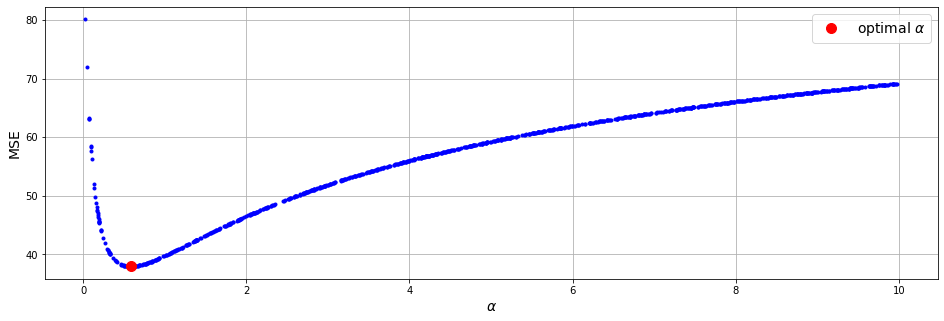

In [43]:
plt.figure(figsize=(16, 5))

scores = -gs_ridge.cv_results_['mean_test_score']

plt.plot(alphas, scores, 'b.')
plt.plot(gs_ridge.best_params_['alpha'], -gs_ridge.best_score_, 'ro', markersize=10, label=r'optimal $\alpha$')
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'MSE', fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.grid()
plt.show()

### Bayesian Ridge Regression

In [44]:
bayes_ridge = BayesianRidge(normalize=True)
bayes_ridge.fit(X_train, y_train)
bayes_pred = bayes_ridge.predict(X_test)

print('Bayesian alpha:', bayes_ridge.alpha_)
print('Test score:', mean_squared_error(y_test, bayes_pred))

Bayesian alpha: 0.04336784287910121
Test score: 35.63904463370705


GridSearch median error: 3.864
Bayes median error: 5.164


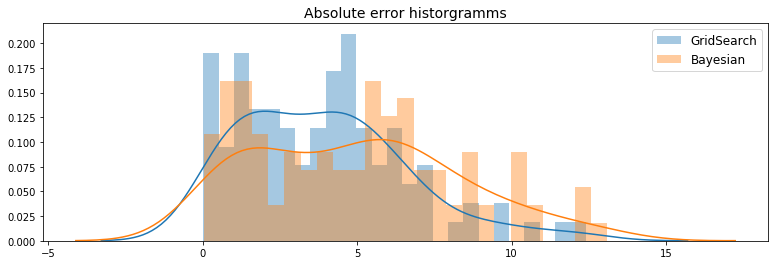

In [45]:
gs_err = np.abs(gs_pred-y_test)
bayes_err = np.abs(bayes_pred-y_test)

plt.figure(figsize=(13, 4))

sns.distplot(gs_err, bins=25, label='GridSearch')
sns.distplot(bayes_err, bins=25, label='Bayesian')

plt.title('Absolute error historgramms', fontsize=14)
plt.legend(loc='best', fontsize=12)

print(f'GridSearch median error: {np.median(gs_err):.3f}')
print(f'Bayes median error: {np.median(bayes_err):.3f}')

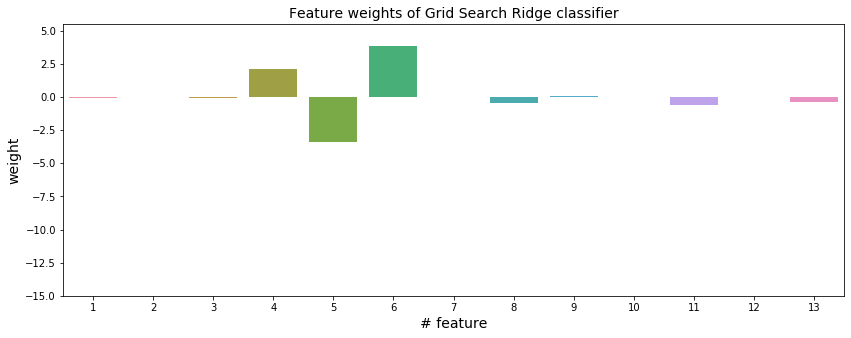

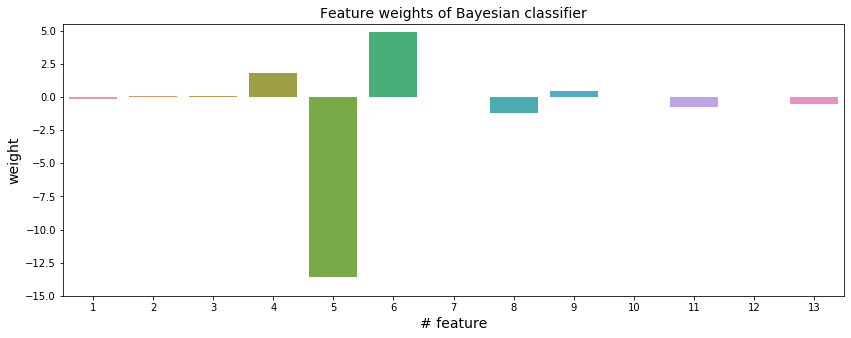

In [46]:
clfs = [best_ridge, bayes_ridge]
names = ['Grid Search Ridge', 'Bayesian']

for name, clf in zip(names, clfs):
    plt.figure(figsize=(14, 5))
    sns.barplot(x=list(range(1, 14)), y=clf.coef_)

    plt.xlabel('# feature', fontsize=14)
    plt.ylabel('weight', fontsize=14)
    plt.title(f'Feature weights of {name} classifier', fontsize=14)
    plt.ylim([-15, 5.5])

    plt.show()

- Bayes Ridge Regression has a bigger median error than Grid Search. It means that Grid Search show the best quality.
- All weights of Grid Search Ridge are less than Bayesian Ridge classifier. It means that Grid Search approach has less overfitting.
- Also MSE train score of Grid Search Ridge is better than Bayesian Ridge.

# Task 4. Stacking (2 point)

Stacking is another approach to combine several algorithms to get better results.Basically stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The main concept is to learn base models on some set of features then train meta model, which uses the predictions of base models as features. This technique is wiledly used in multiple real case scenarios to get better results. One of the main problem of stacking is, of course, overfitting. To avoid it, the training set is divided into $ n $ folds, $ (n-1) $ of which are used for training the base models, and $ n $ -th for the overall prediction (calculating the meta-factor). In order to train the meta-model, it should receive predictions from the base models for those objects of the training sample on which the meta-model will be trained. 

There are various of stacking approaches$.^{[1]}$ For example, in order, to obtain meta-factors for test data, the base classifiers can be trained on the entire training set, since the problem of overfitting does not arise here. In other words, if we want to calculate the factors for the test set, we can safely use the training set to train the base classifiers. If we want to calculate factors for the training set, then it is necessary to ensure that the classifier does not predict for those objects on which it has been trained$.^{[2]}$ You can read more details about stacking [blockpost](https://blog.statsbot.co/ensemble-learning-d1dcd548e936), [kaggle ensemble guide](https://mlwave.com/kaggle-ensembling-guide/).

P.s. Stacking and Blending are two similar approaches to combining classifiers (ensembling). The difference is that Stacking uses out-of-fold predictions for the train set, and Blending uses a validation set to train the next layer [source](quora.com/What-are-examples-of-blending-and-stacking-in-Machine-Learning). Because they are so similar you can use any of them. 

[1] http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf  
[2] MLgroup SHAD

**The task:**

* Complete the ```meta_classfier``` function
* Choose 6 different base models(base models can be any models that you know, and can differ between each other by different hyperparameters, models of ml,features e.t.c) and train them.
* Report individual scores on test set for each of the models. As a score use accuracy.
* Train metaclassifier on original datasets features, report score on test.
* Train meta_classifier on those base models. Report the test score (accuracy) in this case.
* Does stacking helped to gain better score?

Enough of theory, let's get back to Practice. Download dataset fetch_covertype from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype) and  split it train-test - 60/40.
More detail about this dataset you can find [here](https://archive.ics.uci.edu/ml/datasets/Covertype)

In [0]:
PATH_TO_MODELS = 'models'

!mkdir -p $PATH_TO_MODELS

In [0]:
import sklearn

#My imports
import os
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

In [49]:
fc = sklearn.datasets.fetch_covtype()

X = fc['data']
y = fc['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.4, 
                                                    random_state=RANDOM_STATE, stratify=y)

In [50]:
X_train.shape, X_test.shape

((348607, 54), (232405, 54))

Write meta classifier function.

In [0]:
def meta_classifier(base_clfs, final_classifier, X_train, X_test, y_train, cv):
    """
    Meta classifier prediction using stacking. 
    Input:
    :param base_clfs: list,  base classifiers which will be stacked together.
    :param final_classifier: estimator, a classifier which will be used to combine the base estimators. 
    :param X_train: numpy array or pandas table, train set.
    :param X_test: numpy array or pandas table, target for train set.
    :param X_train: numpy array or pandas table, test set.
    
    Output:
    :param y_pred: numpy array or pandas table, prediction of meta classifier using stacking on test set.
    :param final_classifier(optional): estimator, trained final_calssifier.


    More details https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
    
    """
    ###YOUR CODE###
    pass


class Stacking:
    def __init__(self, base_clfs, final_classifier, cv=3):   
        self.base_clfs = base_clfs
        self.final_classifier = clone(final_classifier)
        self.cv = cv
        
        self._clf_names = [type(c).__name__ for c in base_clfs]

    def _fit_predict_base_clfs(self, X_train, y_train, X_test, verbose=False):
        fold_predictions = []
        for name, clf in zip(self._clf_names, self.base_clfs):
            if verbose:
                print(f'\t{name}:', end=' ')
                t_cv = time()

            clf.fit(X_train, y_train)
  
            if verbose:
                print(f'{time()-t_cv:.3f} sec')

            fold_predictions.append(clf.predict_proba(X_test))

        return fold_predictions

    def fit(self, X, y, verbose=False):

        if verbose:
            t_fit = time()
        
        kfold = KFold(n_splits=self.cv, shuffle=True, random_state=RANDOM_STATE)
        kf = kfold.split(X)
        
        meta_features = []
        meta_labels = []

        for i, (train_idxs, pred_idxs) in enumerate(kf, 1):
            if verbose:
                print(f'Fold {i}:')
                t_fold = time()

            X_train, y_train = X[train_idxs], y[train_idxs]
            X_pred, y_pred = X[pred_idxs], y[pred_idxs]
            meta_labels.append(y_pred)

            fold_predictions = self._fit_predict_base_clfs(X_train, y_train, X_pred, verbose)
            meta_features.append(np.hstack(fold_predictions))
            
            if verbose:
                print(f'Fold {i}: {time()-t_fold:.3f} sec\n')

        meta_features = np.concatenate(meta_features)
        y_meta = np.concatenate(meta_labels)

        if verbose:
            print('Full data fitting:')
        for name, clf in zip(self._clf_names, self.base_clfs):
            if verbose:
                print(f'\t{name}:', end=' ')
                t = time()
            clf.fit(X, y)
            if verbose:
                print(f'{time()-t:.3f} sec')

        if verbose:
            print('\nFinal classifier:', end=' ')
            t_final = time()

        self.final_classifier.fit(meta_features, y_meta)

        if verbose:
            print(f'{time()-t_final:.3f} sec\n')
            print(f'Fitting time: {(time() - t_fit)/60:.2f} min')

        return self

    def predict(self, X):
        meta_features = []

        meta_features = [clf.predict_proba(X) for clf in self.base_clfs]
        meta_features = np.hstack(meta_features)
        
        return self.final_classifier.predict(meta_features)

    def dump(self, file):
        with open(file, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file):
        with open(file, 'rb') as f:
            st = pickle.load(f)

        return st

Chose 6 different base models(base models can be any models that you know,and can differ with each other by different hyperparameters,  models of ml,features e.t.c) and train them. 

In [0]:
def dump_models(clfs, clf_names):
    for name, clf in zip(clf_names, clfs):
       

        with open(os.path.join(PATH_TO_MODELS, f'{name}.pkl'), 'wb') as f:
            pickle.dump(clf, f)
            
def load_models(clf_names):
    clfs = []
    for name in clf_names:
        with open(os.path.join(PATH_TO_MODELS, f'{name}.pkl'), 'rb') as f:
            clfs.append(pickle.load(f))
    
    return clfs

In [53]:
###YOUR CODE###
clf_names = ['decision_tree', 'knn', 'xgb', 
             'gauss_nb', 'logreg', 'rf'
            ]

if IS_FITTING:
    
    decision_tree = DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE)
    gauss_nb = GaussianNB()
    logreg = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1, random_state=RANDOM_STATE)
    rf = RandomForestClassifier(n_estimators=300, max_depth=3, n_jobs=-1, random_state=RANDOM_STATE)
    knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    xgb = XGBClassifier(n_estimators=300, max_depth=3, n_jobs=-1, random_state=RANDOM_STATE)

    clfs = [decision_tree, knn, xgb, 
            gauss_nb, logreg, rf
           ]

    for name, clf in zip(clf_names, clfs):
        t = time()
        clf.fit(X_train, y_train)

        print(f'{name}: {time()-t:.3f} sec')

    dump_models(clfs, clf_names)

else:
    clfs = load_models(clf_names)

decision_tree: 2.895 sec
knn: 5.767 sec
xgb: 820.480 sec
gauss_nb: 0.317 sec
logreg: 40.972 sec
rf: 50.438 sec


Report individual scores on test set. As a score use accuracy.

In [54]:
###YOUR CODE###
print('Test accuracy:')
for name, clf in zip(clf_names, clfs):
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f'\t{name}: {score:.4f}')

Test accuracy:
	decision_tree: 0.7154
	knn: 0.9642
	xgb: 0.7760
	gauss_nb: 0.4593
	logreg: 0.6192
	rf: 0.6583


Train metaclassifier on original datasets features. And report score on test.

In [55]:
###YOUR CODE###
meta_clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1, random_state=RANDOM_STATE)
meta_clf.fit(X_train, y_train)

y_pred = meta_clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f'Metaclassifier accuracy: {score:.3f}')

Metaclassifier accuracy: 0.619


Train meta_classifier on those base models .

In [56]:
###YOUR CODE###
stacking_model_path = os.path.join(PATH_TO_MODELS, 'stacking.pkl')

if IS_FITTING:
    st = Stacking(clfs, meta_clf, cv=3)

    st.fit(X_train, y_train, verbose=True)
    st.dump(stacking_model_path)
else:
    st = Stacking.load(stacking_model_path)

Fold 1:
	DecisionTreeClassifier: 2.050 sec
	KNeighborsClassifier: 3.761 sec
	XGBClassifier: 532.470 sec
	GaussianNB: 0.220 sec
	LogisticRegression: 27.842 sec
	RandomForestClassifier: 32.064 sec
Fold 1: 617.025 sec

Fold 2:
	DecisionTreeClassifier: 1.853 sec
	KNeighborsClassifier: 3.335 sec
	XGBClassifier: 533.936 sec
	GaussianNB: 0.231 sec
	LogisticRegression: 27.579 sec
	RandomForestClassifier: 30.763 sec
Fold 2: 615.982 sec

Fold 3:
	DecisionTreeClassifier: 1.924 sec
	KNeighborsClassifier: 3.671 sec
	XGBClassifier: 534.321 sec
	GaussianNB: 0.240 sec
	LogisticRegression: 28.443 sec
	RandomForestClassifier: 31.772 sec
Fold 3: 618.980 sec

Full data fitting:
	DecisionTreeClassifier: 3.051 sec
	KNeighborsClassifier: 5.555 sec
	XGBClassifier: 823.587 sec
	GaussianNB: 0.712 sec
	LogisticRegression: 40.748 sec
	RandomForestClassifier: 49.932 sec

Final classifier: 35.884 sec

Fitting time: 46.86 min


Report score(accuracy) on test. 

In [57]:
%%time
###YOUR CODE###
st_pred = st.predict(X_test)

print(f'Stacking accuracy: {accuracy_score(y_test, st_pred):.4f}')

Stacking accuracy: 0.9649
CPU times: user 1min 8s, sys: 244 ms, total: 1min 8s
Wall time: 35.3 s


Does stacking helped to gain better score?

Your answer

- Yep, but the difference between Stacking and KNN is only 0.0007. The result is good for Kagle, but Stacking is not necessary for real problems. 

- KNN classifier is good for this dataset and Stacking can not make the result significantly better.

# Task 5. Gaussian Processes (1 point)

In the following exercise you will need to fit the gaussian process with different kernels on the ```elecricity_conpumption_FR.csv``` time series data. We have already loaded and prepared the train/test datasets for you below.

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction. Fit a GP and run the predict on the test. Useful kernels to combine: `GPy.kern.RBF, GPy.kern.Poly, GPy.kern.StdPeriodic, GPy.kern.White, GPy.kern.Linear`. 

**The task**:
* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.
* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
data = pd.read_csv('data/elecricity_conpumption_FR.csv')
data.dropna(inplace=True)

In [0]:
y = np.array(data.values)
X = np.array(data.index)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.

In [0]:
###YOUR CODE###
std = StandardScaler()

y_train_std = std.fit_transform(y_train)
y_test_std = std.transform(y_test)

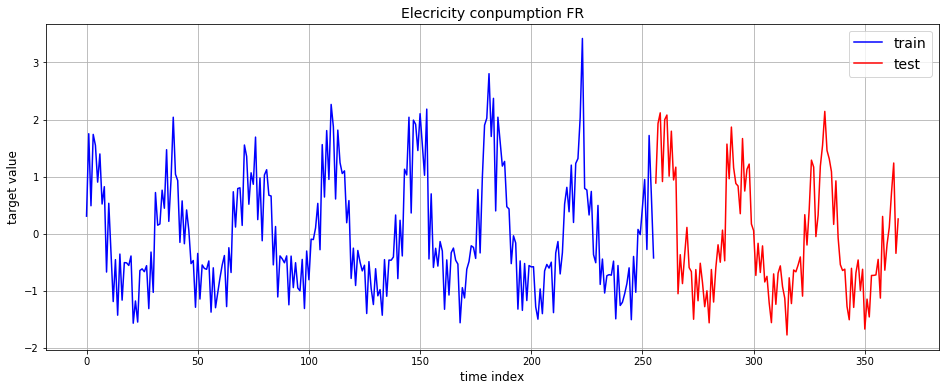

In [63]:
plt.figure(figsize=(16, 6))

plt.plot(X_train, y_train_std, 'b', label='train')
plt.plot(X_test, y_test_std, 'r', label='test')

plt.xlabel('time index', fontsize=12)
plt.ylabel('target value', fontsize=12)
plt.title('Elecricity conpumption FR', fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.grid()
plt.show()

In [64]:
!pip install GPy==1.9.9

     |████████████████████████████████| 1.0MB 2.8MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2634001 sha256=b88378cef25ed9d79085385f98859663234a8a5827a733529fa29b927900fae7
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=e729eb1ceab771a5d84249e2af698ee9bfc32fd08d8a36e5f48ab45abff65e69
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [0]:
from GPy.models import GPRegression
from GPy.kern import RBF, Poly, StdPeriodic, White, Linear, PeriodicExponential
from sklearn.metrics import r2_score
import GPy.kern as kern

* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

In [0]:
###YOUR CODE###
def plot_model(X_train, y_train, X_test, y_test, model, figsize=(16, 6), title=''):
    
    train_num = len(X_train)
    
    X = np.vstack((X_train, X_test))
    mean_pred, var_pred = model.predict(X)
    std_pred = np.sqrt(var_pred).ravel()
    mean_pred = mean_pred.ravel()

    plt.figure(figsize=figsize)

    plt.plot(X.ravel()[:train_num], y_train.ravel(), 'ro', label='train data')
    plt.plot(X.ravel()[train_num:], y_test.ravel(), 'go', label='test data')
    plt.plot(X.ravel(), mean_pred, 'b', label='mean_pred')
    plt.fill_between(X.ravel(), mean_pred - std_pred, mean_pred + std_pred, alpha=0.3, label='std_pred')

    plt.title(title, fontsize=14)
    plt.xlabel('time index', fontsize=12)
    plt.ylabel('values', fontsize=12)
    plt.legend(loc='best', fontsize=12)

    plt.grid()
    plt.show()


Name : GP regression
Objective : 216.6920669582583
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  GP_regression.                |               value  |  constraints  |  priors
  sum.std_periodic.variance     |   1.001477616317261  |      +ve      |        
  sum.std_periodic.period       |  1.0281898415279684  |      +ve      |        
  sum.std_periodic.lengthscale  |  0.6768919292040968  |      +ve      |        
  sum.mul.rbf.variance          |  0.1420939465901039  |      +ve      |        
  sum.mul.rbf.lengthscale       |   8.371320585288094  |      +ve      |        
  sum.mul.rbf_1.variance        |  0.1420939465901039  |      +ve      |        
  sum.mul.rbf_1.lengthscale     |   8.371320585288094  |      +ve      |        
  Gaussian_noise.variance       |  0.2749452421752279  |      +ve      |        


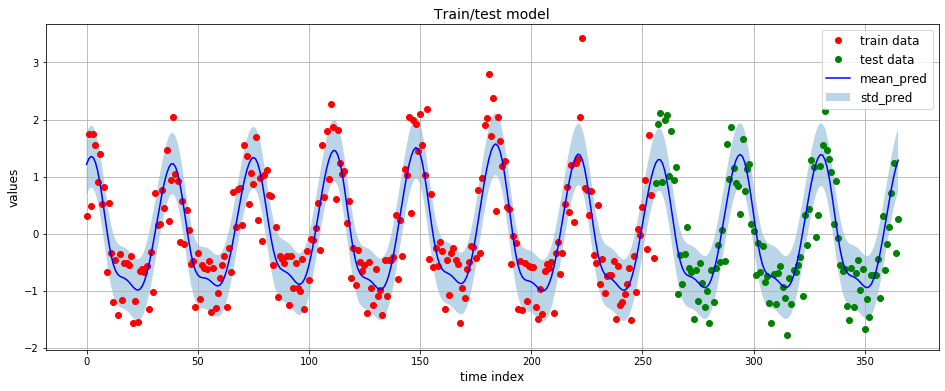

In [67]:
kernel = StdPeriodic(1) + RBF(1)*RBF(1)
model = GPRegression(X_train, y_train_std, kernel)

model.optimize()
print(model)
plot_model(X_train, y_train_std, X_test, y_test_std, model, title='Train/test model')

In [68]:
y_pred = model.predict(X_test)[0]
print('R2-score:', r2_score(y_test_std, y_pred))

R2-score: 0.7116025301607374
